# FINS3666: Trading and Market Making
# Final Project: Crypto Stat Arbitrage Trading Strategy

Group: ...

We use Bitcoin USD as our spot asset and identify arbitrage opportunities with the IBIT ETF and Bitcoin Futures. Utilize daily close prices from January to March 2025 to build this strategy.

The first two months of data are used as training data to tune the trading parameters. Specifically, we determine the mean and standard deviations of price difference between the ETF or Futures and the spot rate.

This information is then used to calculate z-scores during the testing phase. The z-scores help us to calculate and identify entry and exit points for our trading strategy. 

A Z-score above +1 or below –1 is typically an extreme deviation and potential mispricing. For trade entry criteria, trade should be initiated when the z-score rises above +1, which indicates that the futures or ETF is significantly overpriced compared to the spot price. This presents a short opportunity on the future of ETF and going long on the spot price. In contrast, if the z-score drops below -1, it indicates that the futures or ETF is undervalued relative to the spot price. The strategy would go long the futures or ETF and short the spot. This strategy allows the trader to remain market neutral with both long and short positions offsetting the overall BTC directional exposure to minimise risk.

The exit criteria for this strategy include both take profit and stop loss levels based on the z-score. The primary signal to exit a trade occurs when the z-score falls back within the range between -0.5 to 0.5. This indicates that the identified mispricing has mostly been corrected, and the instruments have reverted to their original value. Closing the position ensures that profits are captured from this mispricing opportunity and avoids additional risk from holding the trade unnecessarily. Additionally, if the spread fails to converge within 48 hours, it suggests that instruments fail to mean revert as expected. Position should be exited as holding the trade increases risk exposure, and can avoid capital being tied up when the trade isn’t performing well. Risk management is significant to avoid catastrophic losses, stop-loss levels are enforced based on a maximum z-score threshold of ±2, indicating a breakdown in the historical behaviour of the spread. This is helpful to prevent large losses when the market shifts abruptly. 

# Import Libraries and Data

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl

In [171]:
# Path to your Excel file
file_path = 'Cleaned Data.xlsx'

# Load specific sheets into separate DataFrames
btcusd = pd.read_excel(file_path, sheet_name='BTCUSDT_1min_Jan-Mar2025_CLEAN')
ibit = pd.read_excel(file_path, sheet_name='IBIT ETF Price History EOD 2y', skiprows=15)
bitfut = pd.read_excel(file_path, sheet_name='Bitcoin Futures CME Historical ')

# Intro to BTC (USD) Data

In [172]:
btcusd['Open Time'] =  pd.to_datetime(btcusd['Open Time'])

# Create a new column that contains only the date
btcusd['Date'] = btcusd['Open Time'].dt.date

In [173]:
print(btcusd.shape)
btcusd.head(4)

(129599, 13)


,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,Date
0,2025-01-01 00:00:00,93576.00,93610.93,93537.50,93610.93,8.21827,00:01:00,7.689788e+05,2631,3.95157,369757.3265,0,2025-01-01
1,2025-01-01 00:01:00,93610.93,93652.00,93606.20,93652.00,12.14029,00:02:00,1.136551e+06,1273,4.08887,382791.5002,0,2025-01-01
2,2025-01-01 00:02:00,93652.00,93702.15,93635.98,93702.15,11.60597,00:03:00,1.087101e+06,1095,5.86840,549682.8686,0,2025-01-01
3,2025-01-01 00:03:00,93702.14,93702.15,93654.48,93677.98,8.72958,00:04:00,8.177203e+05,1461,2.48203,232486.1131,0,2025-01-01


In [174]:
# average volume traded per minute
print("Average Volume Traded per Minute:", btcusd["Volume"].mean())

Average Volume Traded per Minute: 19.44971814838078


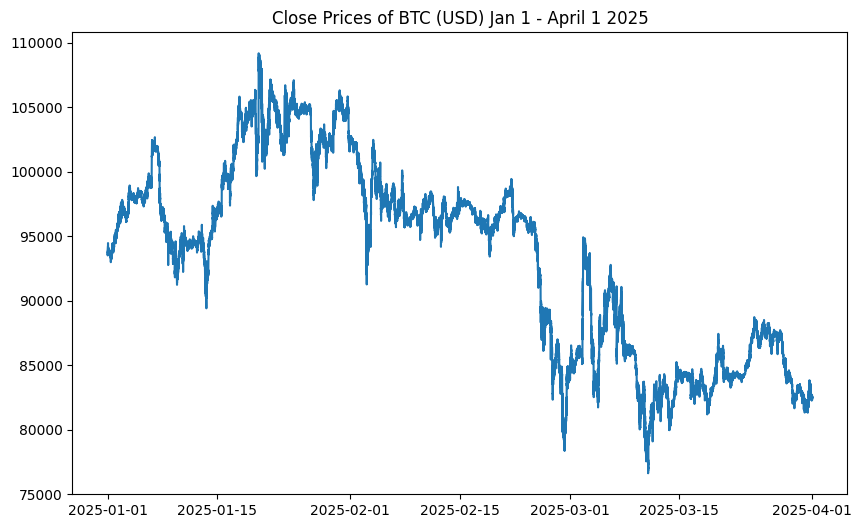

In [175]:
plt.figure(figsize=(10,6));
plt.plot(btcusd["Open Time"], btcusd['Close']);
plt.title("Close Prices of BTC (USD) Jan 1 - April 1 2025");

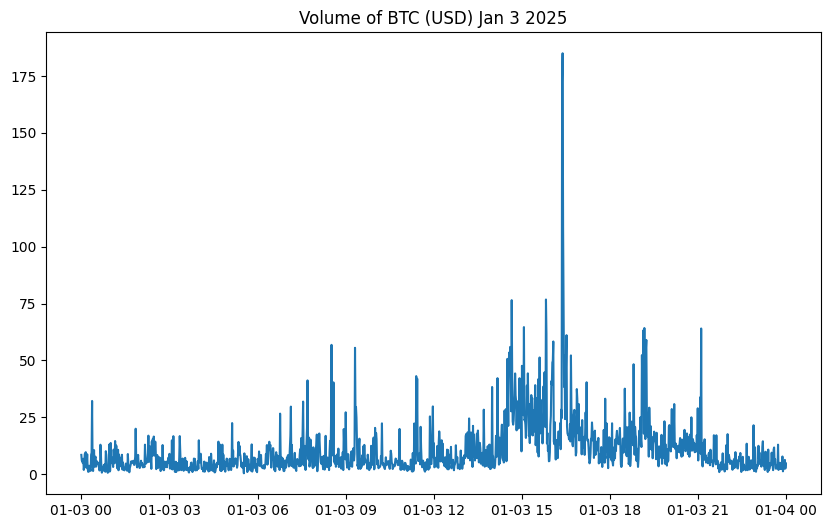

In [176]:
btcusdjan1 = btcusd.copy()
btcusdjan1 = pd.to_datetime(btcusdjan1["Open Time"])
btcusdjan1 = btcusd[btcusd["Open Time"].dt.date == pd.to_datetime('2025-01-03').date()]
plt.figure(figsize=(10,6));
plt.plot(btcusdjan1["Open Time"], btcusdjan1['Volume']);
plt.title("Volume of BTC (USD) Jan 3 2025");

In [177]:
btcusdeod = btcusd.drop_duplicates(subset="Date", keep="last")
btcusdeod.shape

(90, 13)

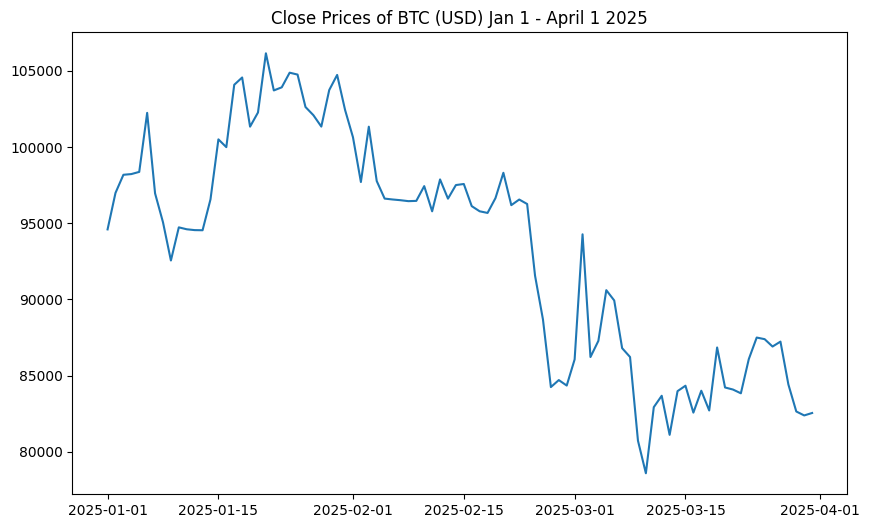

In [178]:
plt.figure(figsize=(10,6));
plt.plot(btcusdeod['Date'], btcusdeod['Close']);
plt.title("Close Prices of BTC (USD) Jan 1 - April 1 2025");

In [179]:
pd.to_datetime(btcusdeod['Date']).describe()

count                     90
mean     2025-02-14 12:00:00
min      2025-01-01 00:00:00
25%      2025-01-23 06:00:00
50%      2025-02-14 12:00:00
75%      2025-03-08 18:00:00
max      2025-03-31 00:00:00
Name: Date, dtype: object

In [180]:
btcusdeod.shape

(90, 13)

# Intro to IBIT and BTC Futures Data

In [181]:
ibit["Close"] = ibit["Price"]
ibit = ibit.drop(columns = ["Price", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13"])
ibit = ibit.dropna()

ibit["AdjustedClose"] = ibit["Close"] * 1755.1
ibit["AdjustedNAV"] = ibit["NAV"] * 1755.1
ibit["Date"] = pd.to_datetime(ibit["Date"])
print(ibit.shape)
ibit.head(4)

(316, 13)


,Date,CVol,% Change,Open,Low,High,NAV,Total Return (Gross),% Return,Cumulative Return %,Close,AdjustedClose,AdjustedNAV
0,2025-04-17,23963580.0,0.625521,48.15,47.615,48.65,48.189744,48.26,0.625521,81.224183,48.26,84701.126,84577.819694
1,2025-04-16,27463000.0,0.460829,47.59,47.355,48.64,47.781660,47.96,0.460829,80.097634,47.96,84174.596,83861.591466
2,2025-04-15,24001680.0,-1.118476,48.80,47.680,49.19,47.769428,47.74,-1.118476,79.271498,47.74,83788.474,83840.123083
3,2025-04-14,32514400.0,1.279631,48.29,47.550,48.81,48.313074,48.28,1.279631,81.299287,48.28,84736.228,84794.276177


In [182]:
pd.to_datetime(ibit["Date"]).describe()

count                              316
mean     2024-08-29 21:52:24.303797504
min                2024-01-12 00:00:00
25%                2024-05-06 18:00:00
50%                2024-08-28 12:00:00
75%                2024-12-20 18:00:00
max                2025-04-17 00:00:00
Name: Date, dtype: object

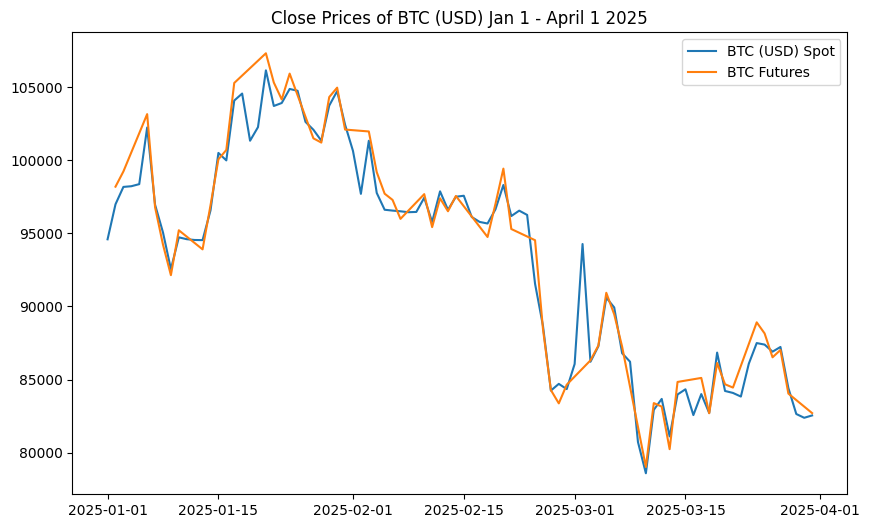

In [183]:
bitfut['Date'] = pd.to_datetime(bitfut["Date"])
bitfut["Close"] = bitfut["Price"]
bitfut = bitfut.drop(columns=["Price"])
plt.figure(figsize=(10,6));
plt.plot(btcusdeod['Date'], btcusdeod['Close'], label="BTC (USD) Spot");
plt.plot(bitfut['Date'], bitfut['Close'], label="BTC Futures");
plt.title("Close Prices of BTC (USD) Jan 1 - April 1 2025");
plt.legend();

In [184]:
print(bitfut.shape)
bitfut.head(4)

(61, 7)


,Date,Open,High,Low,Vol.,Change %,Close
0,2025-03-31,82505,84250,81485,7.92K,-0.0159,82710
1,2025-03-28,87995,88050,83800,11.00K,-0.0342,84045
2,2025-03-27,87130,87785,85805,7.63K,0.0058,87025
3,2025-03-26,87960,88355,85810,8.21K,-0.0185,86525


In [185]:
bitfut["Date"].describe()

count                               61
mean     2025-02-15 04:19:40.327868928
min                2025-01-02 00:00:00
25%                2025-01-24 00:00:00
50%                2025-02-14 00:00:00
75%                2025-03-10 00:00:00
max                2025-03-31 00:00:00
Name: Date, dtype: object

merge data on date for time frame between jan 1 - april 1, 2025
use first 2 months as training data to acquire the mean and standard deviation of ratios of spot to etf and spot to futures
trade on the last month using the zscore mean reversion strategy 
calculate the metrics of trading. one set of trades for etf vs spot. and another set of trades for futures vs spot. use the same method as activity 3 for the class

# Merge All Data


In [186]:
# Add suffixes to all columns except 'timestamp'
spot_df = btcusdeod.rename(columns={col: f"{col}_spot" for col in btcusdeod.columns if col != 'Date'})
futures_df = bitfut.rename(columns={col: f"{col}_futures" for col in bitfut.columns if col != 'Date'})
ibit_df = ibit.rename(columns={col: f"{col}_ibit" for col in ibit.columns if col != 'Date'})

spot_df["Date"] = pd.to_datetime(spot_df["Date"])
futures_df["Date"] = pd.to_datetime(futures_df["Date"])
ibit_df["Date"] = pd.to_datetime(ibit_df["Date"])


In [187]:
# Merge on timestamp
merged = spot_df.merge(futures_df, on='Date', how='inner')\
                   .merge(ibit_df, on='Date', how='inner')


In [188]:
print(merged.shape)
merged.head(5)

(60, 31)


,Open Time_spot,Open_spot,High_spot,Low_spot,Close_spot,Volume_spot,Close Time_spot,Quote Asset Volume_spot,Number of Trades_spot,Taker Buy Base Asset Volume_spot,...,Open_ibit,Low_ibit,High_ibit,NAV_ibit,Total Return (Gross)_ibit,% Return_ibit,Cumulative Return %_ibit,Close_ibit,AdjustedClose_ibit,AdjustedNAV_ibit
0,2025-01-02 23:59:00,96984.79,96984.79,96984.78,96984.79,1.38423,00:00:00,134249.2473,204,0.52525,...,54.895,54.59,55.730,55.437488,55.37,4.373233,107.923395,55.37,97179.887,97298.335189
1,2025-01-03 23:59:00,98153.67,98174.18,98153.67,98174.18,4.76400,00:00:00,467655.1535,550,2.71606,...,55.230,54.97,56.410,55.995765,55.96,1.065559,110.138941,55.96,98215.396,98278.167151
2,2025-01-06 23:59:00,102230.64,102239.58,102230.63,102235.60,9.59104,00:00:00,980530.2144,587,6.90179,...,56.365,56.24,58.455,58.078500,58.17,3.949249,118.437852,58.17,102094.167,101933.575350
3,2025-01-07 23:59:00,96922.01,96954.61,96917.85,96954.61,6.21334,00:00:00,602216.3799,1196,3.81029,...,57.310,54.58,57.382,54.789287,54.79,-5.810555,105.745400,54.79,96161.929,96160.677614
4,2025-01-08 23:59:00,95068.16,95088.52,95060.61,95060.61,4.33957,00:00:00,412598.6934,836,1.72260,...,54.270,52.51,54.610,53.468851,53.34,-2.646468,100.300413,53.34,93617.034,93843.180390


In [189]:
merged.columns

Index(['Open Time_spot', 'Open_spot', 'High_spot', 'Low_spot', 'Close_spot',
       'Volume_spot', 'Close Time_spot', 'Quote Asset Volume_spot',
       'Number of Trades_spot', 'Taker Buy Base Asset Volume_spot',
       'Taker Buy Quote Asset Volume_spot', 'Ignore_spot', 'Date',
       'Open_futures', 'High_futures', 'Low_futures', 'Vol._futures',
       'Change %_futures', 'Close_futures', 'CVol_ibit', '% Change_ibit',
       'Open_ibit', 'Low_ibit', 'High_ibit', 'NAV_ibit',
       'Total Return (Gross)_ibit', '% Return_ibit',
       'Cumulative Return %_ibit', 'Close_ibit', 'AdjustedClose_ibit',
       'AdjustedNAV_ibit'],
      dtype='object')

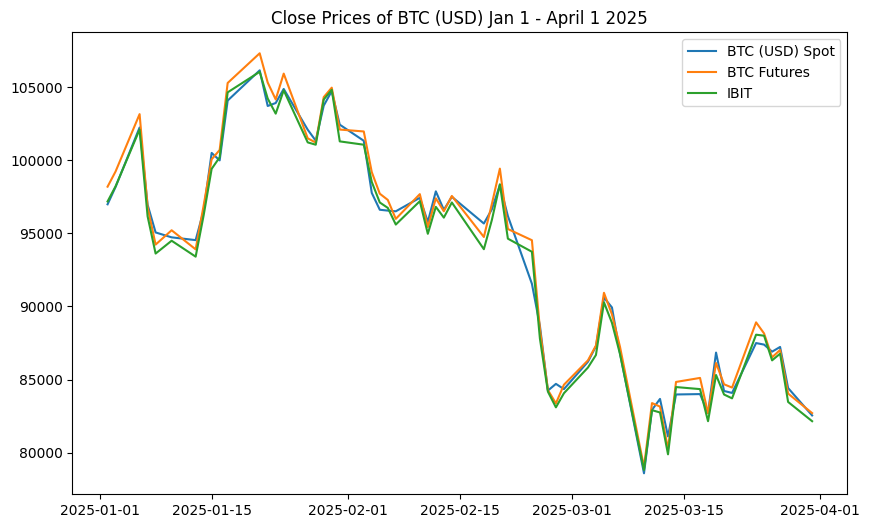

In [190]:
plt.figure(figsize=(10,6));
plt.plot(merged['Date'], merged['Close_spot'], label="BTC (USD) Spot");
plt.plot(merged['Date'], merged['Close_futures'], label="BTC Futures");
plt.plot(merged['Date'], merged['AdjustedClose_ibit'], label="IBIT");
plt.title("Close Prices of BTC (USD) Jan 1 - April 1 2025");
plt.legend();

In [191]:
# train / test split

train = merged[merged["Date"].dt.date <= pd.to_datetime('2025-03-03').date()]
test = merged[merged["Date"].dt.date <= pd.to_datetime('2025-04-01').date()]
test = test[test["Date"].dt.date > pd.to_datetime('2025-03-03').date()]

train.shape, test.shape

((40, 31), (20, 31))

In [192]:
import warnings; warnings.filterwarnings("ignore")

train["ETF_Spot_Diff"] = train["AdjustedClose_ibit"] - train["Close_spot"]
train["Futures_Spot_Diff"] = train["Close_futures"] - train["Close_spot"]

etf_spot_diffmean = train["ETF_Spot_Diff"].mean()
etf_spot_diffstd = train["ETF_Spot_Diff"].std()

futures_spot_diffmean = train["Futures_Spot_Diff"].mean()
futures_spot_diffstd = train["Futures_Spot_Diff"].std()

print("ETF - Spot Diff Mean:", etf_spot_diffmean)
print("ETF - Spot Diff STD:", etf_spot_diffstd)
print("Futures - Spot Diff Mean:", futures_spot_diffmean)
print("Futures - Spot Diff STD:", futures_spot_diffstd)

ETF - Spot Diff Mean: -353.1707500000055
ETF - Spot Diff STD: 755.64052136835
Futures - Spot Diff Mean: 299.02874999999915
Futures - Spot Diff STD: 848.4190364744554


In [193]:
# Calculate the daily spread in the test set
train["ETF_Spot_Diff"] = train["AdjustedClose_ibit"] - train["Close_spot"]
train["Futures_Spot_Diff"] = train["Close_futures"] - train["Close_spot"]

# Calculate Z-score for ETF vs Spot
train["ETF_Spot_ZScore"] = (train["ETF_Spot_Diff"] - etf_spot_diffmean) / etf_spot_diffstd

# Calculate Z-score for Futures vs Spot
train["Futures_Spot_ZScore"] = (train["Futures_Spot_Diff"] - futures_spot_diffmean) / futures_spot_diffstd

train[cols].head(10)

,Date,Close_spot,AdjustedClose_ibit,Close_futures,ETF_Spot_Diff,Futures_Spot_Diff,ETF_Spot_ZScore,Futures_Spot_ZScore
0,2025-01-02,96984.79,97179.887,98190,195.097,1205.21,0.725567,1.068082
1,2025-01-03,98174.18,98215.396,99230,41.216,1055.82,0.521924,0.892002
2,2025-01-06,102235.60,102094.167,103150,-141.433,914.40,0.280210,0.725315
3,2025-01-07,96954.61,96161.929,96785,-792.681,-169.61,-0.581639,-0.552367
4,2025-01-08,95060.61,93617.034,94230,-1443.576,-830.61,-1.443021,-1.331463
5,2025-01-10,94726.11,94494.584,95210,-231.526,483.89,0.160982,0.217889
6,2025-01-13,94536.10,93406.422,93905,-1129.678,-631.10,-1.027615,-1.096308
7,2025-01-14,96560.86,96232.133,96905,-328.727,344.14,0.032348,0.053171
8,2025-01-15,100497.35,99408.864,100060,-1088.486,-437.35,-0.973102,-0.867942
9,2025-01-16,99987.30,100198.659,100700,211.359,712.70,0.747088,0.487579


In [194]:
train["ETF_Spot_ZScore"].describe()

count    4.000000e+01
mean    -2.220446e-17
std      1.000000e+00
min     -1.856926e+00
25%     -6.811119e-01
50%      9.847904e-02
75%      5.481201e-01
max      3.361627e+00
Name: ETF_Spot_ZScore, dtype: float64

# Trading Strategy

In [195]:
# Calculate the daily spread in the test set
test["ETF_Spot_Diff"] = test["AdjustedClose_ibit"] - test["Close_spot"]
test["Futures_Spot_Diff"] = test["Close_futures"] - test["Close_spot"]

# Calculate Z-score for ETF vs Spot
test["ETF_Spot_ZScore"] = (test["ETF_Spot_Diff"] - etf_spot_diffmean) / etf_spot_diffstd

# Calculate Z-score for Futures vs Spot
test["Futures_Spot_ZScore"] = (test["Futures_Spot_Diff"] - futures_spot_diffmean) / futures_spot_diffstd

cols = ["Date", "Close_spot", "AdjustedClose_ibit", "Close_futures", "ETF_Spot_Diff", "Futures_Spot_Diff", "ETF_Spot_ZScore", "Futures_Spot_ZScore"]
test[cols].head(10)

,Date,Close_spot,AdjustedClose_ibit,Close_futures,ETF_Spot_Diff,Futures_Spot_Diff,ETF_Spot_ZScore,Futures_Spot_ZScore
40,2025-03-04,87281.98,86684.389,87330,-597.591,48.02,-0.323461,-0.295855
41,2025-03-05,90606.01,90282.344,90935,-323.666,328.99,0.039046,0.035314
42,2025-03-06,89931.89,88878.264,89460,-1053.626,-471.89,-0.926969,-0.908653
43,2025-03-07,86801.75,86754.593,87250,-47.157,448.25,0.404973,0.175882
44,2025-03-10,78595.86,78821.541,79025,225.681,429.14,0.766041,0.153357
45,2025-03-11,82932.99,82910.924,83395,-22.066,462.01,0.438178,0.192100
46,2025-03-12,83680.12,82752.965,83155,-927.155,-525.12,-0.759600,-0.971394
47,2025-03-13,81115.78,79892.152,80245,-1223.628,-870.78,-1.151946,-1.378810
48,2025-03-14,83983.20,84490.514,84840,507.314,856.80,1.138749,0.657424
49,2025-03-17,84010.03,84350.106,85115,340.076,1104.97,0.917429,0.949933


In [196]:
test["ETF_Spot_ZScore"].describe()

count    20.000000
mean      0.001434
std       0.806062
min      -1.558093
25%      -0.432496
50%      -0.038350
75%       0.520143
max       1.271788
Name: ETF_Spot_ZScore, dtype: float64

In [197]:
test["Futures_Spot_ZScore"].describe()

count    20.000000
mean     -0.159410
std       0.724604
min      -1.378810
25%      -0.801027
50%      -0.064283
75%       0.187326
max       1.317523
Name: Futures_Spot_ZScore, dtype: float64

## ETF-Spot Arbitrage Constant Position Size

### Train Data

In [198]:
# Assuming the dataframe 'df' is already available with columns like 'AdjustedClose_ibit', 'Close_spot'
df = train[cols].copy()


# Add columns to track trade signals and positions
df['Signal'] = ""
df['ETF_Spot_Arb_Trade'] = None
df['ETF_Spot_Trade_Entry_Price'] = None
df['ETF_Spot_Trade_Exit_Price'] = None

# Variables to track our current position
position = None  # 'long', 'short', or None
entry_price_etf = None
entry_price_spot = None
entry_index = None
position_size = 20

zscorethresh = 1

# Loop through the DataFrame to track trades
for idx, row in df.iterrows():
    price_etf = row['AdjustedClose_ibit']
    price_spot = row['Close_spot']
    z_score = row['ETF_Spot_ZScore']  # Z-score column

    # If not in a position, check for an entry signal
    if position is None:
        # Z-score > 2: ETF/Futures overpriced (short ETF, long spot)
        if z_score > zscorethresh:
            position = 'short_etf_long_spot'
            entry_price_etf = price_etf  # Enter short with ETF price
            entry_price_spot = price_spot  # Enter long with Spot price
            entry_index = idx  # Track entry point
            df.at[idx, 'Signal'] = f"Short ETF entry, Long Spot entry, ETF: {entry_price_etf:.4f}, Spot: {entry_price_spot:.4f}, Position size: {position_size}"

        # Z-score < -2: ETF/Futures underpriced (long ETF, short spot)
        elif z_score < -zscorethresh:
            position = 'long_etf_short_spot'
            entry_price_etf = price_etf  # Enter long with ETF price
            entry_price_spot = price_spot  # Enter short with Spot price
            entry_index = idx  # Track entry point
            df.at[idx, 'Signal'] = f"Long ETF entry, Short Spot entry, ETF: {entry_price_etf:.4f}, Spot: {entry_price_spot:.4f}, Position size: {position_size}"
    
    # If in a position, check exit conditions
    elif position == 'short_etf_long_spot':
        # Exit if Z-score is between -0.5 and 0.5 (mean reversion)
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = f"Exit short ETF, long Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score within range), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if 48 hours have passed since entry
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = f"Exit short ETF, long Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (48 hours), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if Z-score exceeds ±3 (Risk management stop-loss)
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = f"Exit short ETF, long Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score threshold), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None
    
    elif position == 'long_etf_short_spot':
        # Exit if Z-score is between -0.5 and 0.5 (mean reversion)
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = f"Exit long ETF, short Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score within range), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if 48 hours have passed since entry
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = f"Exit long ETF, short Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (48 hours), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if Z-score exceeds ±3 (Risk management stop-loss)
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = f"Exit long ETF, short Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score threshold), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

# # Show a sample of the resulting signals and trade details
# df[df['Signal'] != ""][cols+["Signal"]].head(5)


In [199]:
import re

# Create an empty list to store each trade's data.
trades = []
current_trade = {}

for idx, row in df.iterrows():
    signal = row['Signal']
    # Skip if the signal is empty or NaN.
    if pd.isna(signal) or signal.strip() == "":
        continue

    lower = signal.lower()

    # If the signal is an entry signal.
    if "entry" in lower and "exit" not in lower:
        # Split into its comma-separated parts
        parts = signal.split(',')

        # Parse sides
        etf_part  = parts[0].strip()          # e.g. "Long ETF entry"
        spot_part = parts[1].strip()          # e.g. "Short Spot entry"
        side_etf  = "long" if "long etf" in etf_part.lower() else "short"
        side_spot = "long" if "long spot" in spot_part.lower() else "short"

        # Parse prices
        etf_price  = float(parts[2].split(":")[1].strip())
        spot_price = float(parts[3].split(":")[1].strip())

        # Parse position size
        size = float(parts[4].split(":")[1].strip())

        # Begin a new trade record.
        current_trade = {
            "side_etf": side_etf,
            "side_spot": side_spot,
            "etf_price": etf_price,
            "spot_price": spot_price,
            "size": size,
            "entry_idx": idx
        }

    # If the signal is an exit signal.
    elif "exit" in lower:
        # If there's no active trade, skip this exit.
        if not current_trade:
            continue

        parts = signal.split(',')

        # Parse exit prices (and strip any parenthetical note)
        etf_price_exit = float(parts[2].split(":")[1].strip())
        spot_str = parts[3].split(":")[1].strip()
        spot_price_exit = float(re.search(r"[\d\.]+", spot_str).group())

        # Parse exit size and warn if it doesn't match entry size
        size_exit = float(parts[4].split(":")[1].strip())
        if size_exit != current_trade["size"]:
            print(f"Warning: size mismatch at index {idx}")

        # Calculate P&L for the ETF leg
        if current_trade["side_etf"] == "long":
            pnl_etf = (etf_price_exit - current_trade["etf_price"]) * size_exit
        else:
            pnl_etf = (current_trade["etf_price"] - etf_price_exit) * size_exit

        # Calculate P&L for the Spot leg
        if current_trade["side_spot"] == "long":
            pnl_spot = (spot_price_exit - current_trade["spot_price"]) * size_exit
        else:
            pnl_spot = (current_trade["spot_price"] - spot_price_exit) * size_exit

        # Complete the trade record.
        profit = pnl_etf + pnl_spot
        current_trade.update({
            "exit_idx": idx,
            "etf_price_exit": etf_price_exit,
            "spot_price_exit": spot_price_exit,
            "pnl_etf": pnl_etf,
            "pnl_spot": pnl_spot,
            "profit": profit
        })

        trades.append(current_trade)
        current_trade = {}  # Reset for the next trade

# Convert the list of trades into a DataFrame for easier metric calculations.
trades_df = pd.DataFrame(trades)

# Calculate total traded notional amount (sum of ETF + Spot notional each trade).
trades_df["notional_etf"]  = trades_df["etf_price"]  * trades_df["size"]
trades_df["notional_spot"] = trades_df["spot_price"] * trades_df["size"]
trades_df["notional"]      = trades_df["notional_etf"] + trades_df["notional_spot"]
total_amount_traded        = trades_df["notional"].sum()

# Calculate total profit made.
total_profit = trades_df["profit"].sum()

# Percentage return relative to the total notional traded.
percentage_return = (total_profit / total_amount_traded) * 100 if total_amount_traded != 0 else 0

# Additional Metrics:
num_trades              = len(trades_df)
average_profit_per_trade= trades_df["profit"].mean() if num_trades > 0 else 0
win_rate                = (trades_df["profit"] > 0).mean() * 100 if num_trades > 0 else 0
max_profit              = trades_df["profit"].max() if num_trades > 0 else None
max_loss                = trades_df["profit"].min() if num_trades > 0 else None

# Print the metrics.
print(f"Total Amount Traded: ${total_amount_traded:,.2f}")
print(f"Total Profit:        ${total_profit:,.2f}")
print(f"Percentage Return:   {percentage_return:.2f}%")
print(f"Number of Trades:    {num_trades}")
print(f"Average Profit/Trade:${average_profit_per_trade:,.4f}")
print(f"Win Rate:            {win_rate:.2f}%")
print(f"Max Profit on Trade: ${max_profit:,.2f}" if max_profit is not None else "Max Profit on Trade: N/A")
print(f"Max Loss on Trade:   ${max_loss:,.2f}" if max_loss is not None else "Max Loss on Trade: N/A")

Total Amount Traded: $34,912,713.02
Total Profit:        $242,431.64
Percentage Return:   0.69%
Number of Trades:    9
Average Profit/Trade:$26,936.8489
Win Rate:            100.00%
Max Profit on Trade: $74,679.98
Max Loss on Trade:   $11,277.42


### Test Data

In [200]:
# Assuming the dataframe 'df' is already available with columns like 'AdjustedClose_ibit', 'Close_spot'
df = test[cols].copy()


# Add columns to track trade signals and positions
df['Signal'] = ""
df['ETF_Spot_Arb_Trade'] = None
df['ETF_Spot_Trade_Entry_Price'] = None
df['ETF_Spot_Trade_Exit_Price'] = None

# Variables to track our current position
position = None  # 'long', 'short', or None
entry_price_etf = None
entry_price_spot = None
entry_index = None
position_size = 20

zscorethresh = 1

# Loop through the DataFrame to track trades
for idx, row in df.iterrows():
    price_etf = row['AdjustedClose_ibit']
    price_spot = row['Close_spot']
    z_score = row['ETF_Spot_ZScore']  # Z-score column

    # If not in a position, check for an entry signal
    if position is None:
        # Z-score > 2: ETF/Futures overpriced (short ETF, long spot)
        if z_score > zscorethresh:
            position = 'short_etf_long_spot'
            entry_price_etf = price_etf  # Enter short with ETF price
            entry_price_spot = price_spot  # Enter long with Spot price
            entry_index = idx  # Track entry point
            df.at[idx, 'Signal'] = f"Short ETF entry, Long Spot entry, ETF: {entry_price_etf:.4f}, Spot: {entry_price_spot:.4f}, Position size: {position_size}"

        # Z-score < -2: ETF/Futures underpriced (long ETF, short spot)
        elif z_score < -zscorethresh:
            position = 'long_etf_short_spot'
            entry_price_etf = price_etf  # Enter long with ETF price
            entry_price_spot = price_spot  # Enter short with Spot price
            entry_index = idx  # Track entry point
            df.at[idx, 'Signal'] = f"Long ETF entry, Short Spot entry, ETF: {entry_price_etf:.4f}, Spot: {entry_price_spot:.4f}, Position size: {position_size}"
    
    # If in a position, check exit conditions
    elif position == 'short_etf_long_spot':
        # Exit if Z-score is between -0.5 and 0.5 (mean reversion)
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = f"Exit short ETF, long Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score within range), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if 48 hours have passed since entry
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = f"Exit short ETF, long Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (48 hours), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if Z-score exceeds ±3 (Risk management stop-loss)
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = f"Exit short ETF, long Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score threshold), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None
    
    elif position == 'long_etf_short_spot':
        # Exit if Z-score is between -0.5 and 0.5 (mean reversion)
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = f"Exit long ETF, short Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score within range), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if 48 hours have passed since entry
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = f"Exit long ETF, short Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (48 hours), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

        # Exit if Z-score exceeds ±3 (Risk management stop-loss)
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = f"Exit long ETF, short Spot, ETF: {price_etf:.4f}, Spot: {price_spot:.4f} (Z-score threshold), Position size: {position_size}"
            position = None
            entry_price_etf = None
            entry_price_spot = None

# # Show a sample of the resulting signals and trade details
# df[df['Signal'] != ""][cols+["Signal"]].head(5)


In [201]:
import re

# Create an empty list to store each trade's data.
trades = []
current_trade = {}

for idx, row in df.iterrows():
    signal = row['Signal']
    # Skip if the signal is empty or NaN.
    if pd.isna(signal) or signal.strip() == "":
        continue

    lower = signal.lower()

    # If the signal is an entry signal.
    if "entry" in lower and "exit" not in lower:
        # Split into its comma-separated parts
        parts = signal.split(',')

        # Parse sides
        etf_part  = parts[0].strip()          # e.g. "Long ETF entry"
        spot_part = parts[1].strip()          # e.g. "Short Spot entry"
        side_etf  = "long" if "long etf" in etf_part.lower() else "short"
        side_spot = "long" if "long spot" in spot_part.lower() else "short"

        # Parse prices
        etf_price  = float(parts[2].split(":")[1].strip())
        spot_price = float(parts[3].split(":")[1].strip())

        # Parse position size
        size = float(parts[4].split(":")[1].strip())

        # Begin a new trade record.
        current_trade = {
            "side_etf": side_etf,
            "side_spot": side_spot,
            "etf_price": etf_price,
            "spot_price": spot_price,
            "size": size,
            "entry_idx": idx
        }

    # If the signal is an exit signal.
    elif "exit" in lower:
        # If there's no active trade, skip this exit.
        if not current_trade:
            continue

        parts = signal.split(',')

        # Parse exit prices (and strip any parenthetical note)
        etf_price_exit = float(parts[2].split(":")[1].strip())
        spot_str = parts[3].split(":")[1].strip()
        spot_price_exit = float(re.search(r"[\d\.]+", spot_str).group())

        # Parse exit size and warn if it doesn't match entry size
        size_exit = float(parts[4].split(":")[1].strip())
        if size_exit != current_trade["size"]:
            print(f"Warning: size mismatch at index {idx}")

        # Calculate P&L for the ETF leg
        if current_trade["side_etf"] == "long":
            pnl_etf = (etf_price_exit - current_trade["etf_price"]) * size_exit
        else:
            pnl_etf = (current_trade["etf_price"] - etf_price_exit) * size_exit

        # Calculate P&L for the Spot leg
        if current_trade["side_spot"] == "long":
            pnl_spot = (spot_price_exit - current_trade["spot_price"]) * size_exit
        else:
            pnl_spot = (current_trade["spot_price"] - spot_price_exit) * size_exit

        # Complete the trade record.
        profit = pnl_etf + pnl_spot
        current_trade.update({
            "exit_idx": idx,
            "etf_price_exit": etf_price_exit,
            "spot_price_exit": spot_price_exit,
            "pnl_etf": pnl_etf,
            "pnl_spot": pnl_spot,
            "profit": profit
        })

        trades.append(current_trade)
        current_trade = {}  # Reset for the next trade

# Convert the list of trades into a DataFrame for easier metric calculations.
trades_df = pd.DataFrame(trades)

# Calculate total traded notional amount (sum of ETF + Spot notional each trade).
trades_df["notional_etf"]  = trades_df["etf_price"]  * trades_df["size"]
trades_df["notional_spot"] = trades_df["spot_price"] * trades_df["size"]
trades_df["notional"]      = trades_df["notional_etf"] + trades_df["notional_spot"]
total_amount_traded        = trades_df["notional"].sum()

# Calculate total profit made.
total_profit = trades_df["profit"].sum()

# Percentage return relative to the total notional traded.
percentage_return = (total_profit / total_amount_traded) * 100 if total_amount_traded != 0 else 0

# Additional Metrics:
num_trades              = len(trades_df)
average_profit_per_trade= trades_df["profit"].mean() if num_trades > 0 else 0
win_rate                = (trades_df["profit"] > 0).mean() * 100 if num_trades > 0 else 0
max_profit              = trades_df["profit"].max() if num_trades > 0 else None
max_loss                = trades_df["profit"].min() if num_trades > 0 else None

# Print the metrics.
print(f"Total Amount Traded: ${total_amount_traded:,.2f}")
print(f"Total Profit:        ${total_profit:,.2f}")
print(f"Percentage Return:   {percentage_return:.2f}%")
print(f"Number of Trades:    {num_trades}")
print(f"Average Profit/Trade:${average_profit_per_trade:,.4f}")
print(f"Win Rate:            {win_rate:.2f}%")
print(f"Max Profit on Trade: ${max_profit:,.2f}" if max_profit is not None else "Max Profit on Trade: N/A")
print(f"Max Loss on Trade:   ${max_loss:,.2f}" if max_loss is not None else "Max Loss on Trade: N/A")

Total Amount Traded: $10,174,767.22
Total Profit:        $80,369.76
Percentage Return:   0.79%
Number of Trades:    3
Average Profit/Trade:$26,789.9200
Win Rate:            100.00%
Max Profit on Trade: $31,274.08
Max Loss on Trade:   $23,322.20


## Futures-Spot Arbitrage Constant Position Size

In [217]:
### Train

In [218]:
cols = [
    "Date", "Close_spot", "AdjustedClose_ibit", "Close_futures",
    "Futures_Spot_Diff", "Futures_Spot_ZScore"
]
df = train[cols].copy()

# -------------------------------------------------------------------
#  1) Add columns for signals & bookkeeping
# -------------------------------------------------------------------
df['Signal']                       = ""
df['Futures_Spot_Arb_Trade']       = None
df['Futures_Spot_Trade_Entry_Price']= None
df['Futures_Spot_Trade_Exit_Price'] = None

# -------------------------------------------------------------------
#  2) Hyper-parameters & trackers
# -------------------------------------------------------------------
position        = None   # 'short_fut_long_spot', 'long_fut_short_spot', or None
entry_price_fut = None
entry_price_spot= None
entry_index     = None
position_size   = 20
zscorethresh    = 1

# -------------------------------------------------------------------
#  3) Loop to generate signals
# -------------------------------------------------------------------
for idx, row in df.iterrows():
    price_fut = row['Close_futures']
    price_spot= row['Close_spot']
    z_score   = row['Futures_Spot_ZScore']

    # --- ENTRY LOGIC ---
    if position is None:
        # Futures overpriced => short futures, long spot
        if z_score > zscorethresh:
            position         = 'short_fut_long_spot'
            entry_price_fut  = price_fut
            entry_price_spot = price_spot
            entry_index      = idx
            df.at[idx, 'Signal'] = (
                f"Short futures entry, Long spot entry, "
                f"Futures: {entry_price_fut:.4f}, "
                f"Spot: {entry_price_spot:.4f}, "
                f"Position size: {position_size}"
            )

        # Futures underpriced => long futures, short spot
        elif z_score < -zscorethresh:
            position         = 'long_fut_short_spot'
            entry_price_fut  = price_fut
            entry_price_spot = price_spot
            entry_index      = idx
            df.at[idx, 'Signal'] = (
                f"Long futures entry, Short spot entry, "
                f"Futures: {entry_price_fut:.4f}, "
                f"Spot: {entry_price_spot:.4f}, "
                f"Position size: {position_size}"
            )

    # --- EXIT LOGIC FOR short_fut_long_spot ---
    elif position == 'short_fut_long_spot':
        # Mean reversion cross
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = (
                f"Exit short futures, long spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score within range), Position size: {position_size}"
            )
            position = None

        # Time stop: 48 hours
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = (
                f"Exit short futures, long spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(48 hours), Position size: {position_size}"
            )
            position = None

        # Risk stop: extreme z-score
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = (
                f"Exit short futures, long spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score threshold), Position size: {position_size}"
            )
            position = None

    # --- EXIT LOGIC FOR long_fut_short_spot ---
    elif position == 'long_fut_short_spot':
        # Mean reversion cross
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = (
                f"Exit long futures, short spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score within range), Position size: {position_size}"
            )
            position = None

        # Time stop: 48 hours
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = (
                f"Exit long futures, short spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(48 hours), Position size: {position_size}"
            )
            position = None

        # Risk stop: extreme z-score
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = (
                f"Exit long futures, short spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score threshold), Position size: {position_size}"
            )
            position = None



In [224]:

# Create an empty list to store each trade's data.
trades = []
current_trade = {}

for idx, row in df.iterrows():
    signal = row['Signal']
    # Skip if the signal is empty or NaN.
    if pd.isna(signal) or signal.strip() == "":
        continue

    lower = signal.lower()

    # If the signal is an entry signal.
    if "entry" in lower and "exit" not in lower:
        parts = signal.split(',')

        # Parse sides
        fut_part  = parts[0].strip()          # e.g. "Short futures entry"
        spot_part = parts[1].strip()          # e.g. "Long spot entry"
        side_fut  = "long" if "long futures" in fut_part.lower() else "short"
        side_spot = "long" if "long spot"    in spot_part.lower() else "short"

        # Parse prices
        fut_price  = float(parts[2].split(":")[1].strip())
        spot_price = float(parts[3].split(":")[1].strip())

        # Parse position size
        size = float(parts[4].split(":")[1].strip())

        # Begin a new trade record.
        current_trade = {
            "side_fut": side_fut,
            "side_spot": side_spot,
            "fut_price": fut_price,
            "spot_price": spot_price,
            "size": size,
            "entry_idx": idx
        }

    # If the signal is an exit signal.
    elif "exit" in lower:
        # If there's no active trade, skip this exit.
        if not current_trade:
            continue

        parts = signal.split(',')

        # Parse exit prices (strip any parenthetical note)
        fut_price_exit = float(parts[2].split(":")[1].strip())
        spot_str       = parts[3].split(":")[1].strip()
        spot_price_exit= float(re.search(r"[\d\.]+", spot_str).group())

        # Parse exit size and warn if it doesn't match entry size
        size_exit = float(parts[4].split(":")[1].strip())
        if size_exit != current_trade["size"]:
            print(f"Warning: size mismatch at index {idx}")

        # Calculate P&L for the futures leg
        if current_trade["side_fut"] == "long":
            pnl_fut = (fut_price_exit - current_trade["fut_price"]) * size_exit
        else:
            pnl_fut = (current_trade["fut_price"] - fut_price_exit) * size_exit

        # Calculate P&L for the spot leg
        if current_trade["side_spot"] == "long":
            pnl_spot = (spot_price_exit - current_trade["spot_price"]) * size_exit
        else:
            pnl_spot = (current_trade["spot_price"] - spot_price_exit) * size_exit

        # Complete the trade record.
        profit = pnl_fut + pnl_spot
        current_trade.update({
            "exit_idx": idx,
            "fut_price_exit": fut_price_exit,
            "spot_price_exit": spot_price_exit,
            "pnl_fut": pnl_fut,
            "pnl_spot": pnl_spot,
            "profit": profit
        })

        trades.append(current_trade)
        current_trade = {}  # Reset for the next trade

# Convert the list of trades into a DataFrame for easier metric calculations.
trades_df = pd.DataFrame(trades)

# Calculate total traded notional amount (sum of futures + spot notionals each trade).
trades_df["notional_fut"]  = trades_df["fut_price"]  * trades_df["size"]
trades_df["notional_spot"] = trades_df["spot_price"] * trades_df["size"]
trades_df["notional"]      = trades_df["notional_fut"] + trades_df["notional_spot"]
total_amount_traded        = trades_df["notional"].sum()

# Calculate total profit made.
total_profit = trades_df["profit"].sum()

# Percentage return relative to the total notional traded.
percentage_return = (total_profit / total_amount_traded) * 100 if total_amount_traded != 0 else 0

# Additional Metrics:
num_trades               = len(trades_df)
average_profit_per_trade = trades_df["profit"].mean() if num_trades > 0 else 0
win_rate                 = (trades_df["profit"] > 0).mean() * 100 if num_trades > 0 else 0
max_profit               = trades_df["profit"].max() if num_trades > 0 else None
max_loss                 = trades_df["profit"].min() if num_trades > 0 else None

# Print the metrics.
print(f"Total Amount Traded: ${total_amount_traded:,.2f}")
print(f"Total Profit:        ${total_profit:,.2f}")
print(f"Percentage Return:   {percentage_return:.2f}%")
print(f"Number of Trades:    {num_trades}")
print(f"Average Profit/Trade:${average_profit_per_trade:,.4f}")
print(f"Win Rate:            {win_rate:.2f}%")
print(f"Max Profit on Trade: ${max_profit:,.2f}" if max_profit is not None else "Max Profit on Trade: N/A")
print(f"Max Loss on Trade:   ${max_loss:,.2f}" if max_loss is not None else "Max Loss on Trade: N/A")


Total Amount Traded: $34,655,444.80
Total Profit:        $216,513.00
Percentage Return:   0.62%
Number of Trades:    9
Average Profit/Trade:$24,057.0000
Win Rate:            88.89%
Max Profit on Trade: $77,282.00
Max Loss on Trade:   $-8,016.40


### Test Data

In [226]:
cols = [
    "Date", "Close_spot", "AdjustedClose_ibit", "Close_futures",
    "Futures_Spot_Diff", "Futures_Spot_ZScore"
]
df = test[cols].copy()

# -------------------------------------------------------------------
#  1) Add columns for signals & bookkeeping
# -------------------------------------------------------------------
df['Signal']                       = ""
df['Futures_Spot_Arb_Trade']       = None
df['Futures_Spot_Trade_Entry_Price']= None
df['Futures_Spot_Trade_Exit_Price'] = None

# -------------------------------------------------------------------
#  2) Hyper-parameters & trackers
# -------------------------------------------------------------------
position        = None   # 'short_fut_long_spot', 'long_fut_short_spot', or None
entry_price_fut = None
entry_price_spot= None
entry_index     = None
position_size   = 20
zscorethresh    = 1

# -------------------------------------------------------------------
#  3) Loop to generate signals
# -------------------------------------------------------------------
for idx, row in df.iterrows():
    price_fut = row['Close_futures']
    price_spot= row['Close_spot']
    z_score   = row['Futures_Spot_ZScore']

    # --- ENTRY LOGIC ---
    if position is None:
        # Futures overpriced => short futures, long spot
        if z_score > zscorethresh:
            position         = 'short_fut_long_spot'
            entry_price_fut  = price_fut
            entry_price_spot = price_spot
            entry_index      = idx
            df.at[idx, 'Signal'] = (
                f"Short futures entry, Long spot entry, "
                f"Futures: {entry_price_fut:.4f}, "
                f"Spot: {entry_price_spot:.4f}, "
                f"Position size: {position_size}"
            )

        # Futures underpriced => long futures, short spot
        elif z_score < -zscorethresh:
            position         = 'long_fut_short_spot'
            entry_price_fut  = price_fut
            entry_price_spot = price_spot
            entry_index      = idx
            df.at[idx, 'Signal'] = (
                f"Long futures entry, Short spot entry, "
                f"Futures: {entry_price_fut:.4f}, "
                f"Spot: {entry_price_spot:.4f}, "
                f"Position size: {position_size}"
            )

    # --- EXIT LOGIC FOR short_fut_long_spot ---
    elif position == 'short_fut_long_spot':
        # Mean reversion cross
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = (
                f"Exit short futures, long spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score within range), Position size: {position_size}"
            )
            position = None

        # Time stop: 48 hours
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = (
                f"Exit short futures, long spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(48 hours), Position size: {position_size}"
            )
            position = None

        # Risk stop: extreme z-score
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = (
                f"Exit short futures, long spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score threshold), Position size: {position_size}"
            )
            position = None

    # --- EXIT LOGIC FOR long_fut_short_spot ---
    elif position == 'long_fut_short_spot':
        # Mean reversion cross
        if -0.5 <= z_score <= 0.5:
            df.at[idx, 'Signal'] = (
                f"Exit long futures, short spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score within range), Position size: {position_size}"
            )
            position = None

        # Time stop: 48 hours
        elif (idx - entry_index) >= 2:
            df.at[idx, 'Signal'] = (
                f"Exit long futures, short spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(48 hours), Position size: {position_size}"
            )
            position = None

        # Risk stop: extreme z-score
        elif z_score >= zscorethresh + 1 or z_score <= -zscorethresh - 1:
            df.at[idx, 'Signal'] = (
                f"Exit long futures, short spot, "
                f"Futures: {price_fut:.4f}, Spot: {price_spot:.4f} "
                f"(Z-score threshold), Position size: {position_size}"
            )
            position = None



In [227]:

# Create an empty list to store each trade's data.
trades = []
current_trade = {}

for idx, row in df.iterrows():
    signal = row['Signal']
    # Skip if the signal is empty or NaN.
    if pd.isna(signal) or signal.strip() == "":
        continue

    lower = signal.lower()

    # If the signal is an entry signal.
    if "entry" in lower and "exit" not in lower:
        parts = signal.split(',')

        # Parse sides
        fut_part  = parts[0].strip()          # e.g. "Short futures entry"
        spot_part = parts[1].strip()          # e.g. "Long spot entry"
        side_fut  = "long" if "long futures" in fut_part.lower() else "short"
        side_spot = "long" if "long spot"    in spot_part.lower() else "short"

        # Parse prices
        fut_price  = float(parts[2].split(":")[1].strip())
        spot_price = float(parts[3].split(":")[1].strip())

        # Parse position size
        size = float(parts[4].split(":")[1].strip())

        # Begin a new trade record.
        current_trade = {
            "side_fut": side_fut,
            "side_spot": side_spot,
            "fut_price": fut_price,
            "spot_price": spot_price,
            "size": size,
            "entry_idx": idx
        }

    # If the signal is an exit signal.
    elif "exit" in lower:
        # If there's no active trade, skip this exit.
        if not current_trade:
            continue

        parts = signal.split(',')

        # Parse exit prices (strip any parenthetical note)
        fut_price_exit = float(parts[2].split(":")[1].strip())
        spot_str       = parts[3].split(":")[1].strip()
        spot_price_exit= float(re.search(r"[\d\.]+", spot_str).group())

        # Parse exit size and warn if it doesn't match entry size
        size_exit = float(parts[4].split(":")[1].strip())
        if size_exit != current_trade["size"]:
            print(f"Warning: size mismatch at index {idx}")

        # Calculate P&L for the futures leg
        if current_trade["side_fut"] == "long":
            pnl_fut = (fut_price_exit - current_trade["fut_price"]) * size_exit
        else:
            pnl_fut = (current_trade["fut_price"] - fut_price_exit) * size_exit

        # Calculate P&L for the spot leg
        if current_trade["side_spot"] == "long":
            pnl_spot = (spot_price_exit - current_trade["spot_price"]) * size_exit
        else:
            pnl_spot = (current_trade["spot_price"] - spot_price_exit) * size_exit

        # Complete the trade record.
        profit = pnl_fut + pnl_spot
        current_trade.update({
            "exit_idx": idx,
            "fut_price_exit": fut_price_exit,
            "spot_price_exit": spot_price_exit,
            "pnl_fut": pnl_fut,
            "pnl_spot": pnl_spot,
            "profit": profit
        })

        trades.append(current_trade)
        current_trade = {}  # Reset for the next trade

# Convert the list of trades into a DataFrame for easier metric calculations.
trades_df = pd.DataFrame(trades)

# Calculate total traded notional amount (sum of futures + spot notionals each trade).
trades_df["notional_fut"]  = trades_df["fut_price"]  * trades_df["size"]
trades_df["notional_spot"] = trades_df["spot_price"] * trades_df["size"]
trades_df["notional"]      = trades_df["notional_fut"] + trades_df["notional_spot"]
total_amount_traded        = trades_df["notional"].sum()

# Calculate total profit made.
total_profit = trades_df["profit"].sum()

# Percentage return relative to the total notional traded.
percentage_return = (total_profit / total_amount_traded) * 100 if total_amount_traded != 0 else 0

# Additional Metrics:
num_trades               = len(trades_df)
average_profit_per_trade = trades_df["profit"].mean() if num_trades > 0 else 0
win_rate                 = (trades_df["profit"] > 0).mean() * 100 if num_trades > 0 else 0
max_profit               = trades_df["profit"].max() if num_trades > 0 else None
max_loss                 = trades_df["profit"].min() if num_trades > 0 else None

# Print the metrics.
print(f"Total Amount Traded: ${total_amount_traded:,.2f}")
print(f"Total Profit:        ${total_profit:,.2f}")
print(f"Percentage Return:   {percentage_return:.2f}%")
print(f"Number of Trades:    {num_trades}")
print(f"Average Profit/Trade:${average_profit_per_trade:,.4f}")
print(f"Win Rate:            {win_rate:.2f}%")
print(f"Max Profit on Trade: ${max_profit:,.2f}" if max_profit is not None else "Max Profit on Trade: N/A")
print(f"Max Loss on Trade:   ${max_loss:,.2f}" if max_loss is not None else "Max Loss on Trade: N/A")


Total Amount Traded: $10,215,097.60
Total Profit:        $98,886.20
Percentage Return:   0.97%
Number of Trades:    3
Average Profit/Trade:$32,962.0667
Win Rate:            100.00%
Max Profit on Trade: $39,515.00
Max Loss on Trade:   $23,351.00
